# Market comparison - Asian options
In this final notebook, we use actual marked data from `yfinance` to historically backtest our pricing model for Asian options.  We will take windows over historical data and compare the actual (discounted) payout of an array of Asian options to the expected one for geometric calls (from the formula) and arithmetic calls (from the Monte-Carlo simulation).  We will use realized volatility in the previous month as volatility in the GBM model.

As in the previous market comparison notebook, we will look at the following tickers:
- SPDR S&P 500 ETF Trust (`SPY`),
- Vanguard Total Stock Market Index Fund ETF (`VTI`),
- Apple Inc (`AAPL`),
- Microsoft Corp (`MSFT`).

We will take the start date of the historical series to be Jan 1, 2019, and the end date to be Dec 31, 2024.  We will look at options expiring in 10 days, and compute realized volatility in the 21 days before the call contract is established.  Averages will be taken daily.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from brokenaxes import brokenaxes

sns.set_style("darkgrid")

from utils import gao_price, monte_carlo_asian


# function to annualize realized vol
def realized_vol(series, window_days=60):
    # log returns
    lr = np.log(series).diff().dropna()
    return lr.rolling(window_days).std() * np.sqrt(252)

### `SPY`

In [2]:
# --- CONFIG ---
ticker = "SPY"
expiry_days = 10  # length of Asian contract in calendar days
trail_window = 21  # days to compute realized vol before t0
r = 0.045  # risk-free rate (annual)
n_sims = 20_000  # MC paths for model pricing
n_steps = expiry_days  # MC time steps approx 1 per day
K_rel_values = [0.8, 0.9, 1.0, 1.1, 1.2]  # strike relative to spot, e.g., 1.0 = ATM
start_date = "2019-01-01"  # historical range start
end_date = "2024-12-31"  # historical range end

# helper: daily trading days ~ use business days index
prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()

# compute rolling realized vol series (one-sided trailing)
rv = realized_vol(prices, window_days=trail_window)

# choose t0 dates where we have enough trailing data and future window
all_dates = prices.index
usable_dates = []
for t0 in all_dates:
    # require t0 to have trailing window and future expiry window
    t0_idx = all_dates.get_loc(t0)
    if t0_idx - trail_window < 0:
        continue
    # compute end index for expiry
    expiry_date = t0 + pd.Timedelta(days=expiry_days)
    # find nearest trading day >= expiry_date
    if expiry_date > all_dates[-1]:
        break
    # we need expiry to be in index
    # find first trading day >= expiry_date
    future_idx = all_dates.get_indexer([expiry_date], method="bfill")[0]
    if future_idx == -1 or future_idx >= len(all_dates):
        continue
    # accept t0
    usable_dates.append(t0)

# # For speed, subsample usable_dates
# usable_dates = usable_dates[::20]

results = []
for t0 in usable_dates:
    for K_rel in K_rel_values:
        # get S0 at t0
        S0 = float(prices.loc[t0])
        # strike
        K = K_rel * S0

        # compute realized vol at t0 using trailing window
        sigma_t0 = float(rv.loc[t0])
        if np.isnan(sigma_t0) or sigma_t0 <= 0:
            continue

        # determine expiry trading day index
        expiry_date = t0 + pd.Timedelta(days=expiry_days)
        expiry_idx = prices.index.get_indexer([expiry_date], method="bfill")[0]
        T_days = expiry_idx - prices.index.get_indexer([t0])[0]
        # convert to years
        T_years = T_days / 252.0

        # --- Model price at t0 using realized vol ---
        # geometric
        model_G_price = gao_price(S0, K, sigma_t0, T_years, r)
        # arithmetic
        model_A_price = monte_carlo_asian(
            S0, K, sigma_t0, T_years, r, 0, n_sims, n_steps, return_distribution=False
        )

        # --- Empirical realized payoff computed from actual future prices ---
        # we need the actual average from t0->expiry_date inclusive
        # get slice of future prices from the first trading day after t0 up to expiry_idx
        t0_idx = prices.index.get_loc(t0)
        future_slice = prices.iloc[
            t0_idx + 1 : expiry_idx + 1
        ]  # average over next T_days (exclude t0)
        if len(future_slice) == 0:
            continue

        # geometric average
        G_T = np.exp(np.mean(np.log(future_slice)))
        discounted_G_payoff = max(G_T - K, 0) * np.exp(-r * T_years)

        # arithmetic average
        A_T = np.mean(future_slice)
        discounted_A_payoff = max(A_T - K, 0) * np.exp(-r * T_years)

        # store
        results.append(
            {
                "t0": t0,
                "S0": S0,
                "K": K,
                "K_rel": K_rel,
                "sigma_t0": sigma_t0,
                "T_years": T_years,
                "geom_model": model_G_price,
                "arit_model": model_A_price,
                "geom_empirical": discounted_G_payoff,
                "arit_empirical": discounted_A_payoff,
            }
        )

spy_results = pd.DataFrame(results)
spy_results = spy_results.dropna().reset_index(drop=True)
spy_results.to_csv(f"outputs/{ticker}_asian.csv")
spy_results

/tmp/ipykernel_17917/2766722917.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_17917/2766722917.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.loc[t0])
/tmp/ipykernel_17917/2766722917.py:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_t0 = float(rv.loc[t0])


,t0,S0,K,K_rel,sigma_t0,T_years,geom_model,arit_model,geom_empirical,arit_empirical
0,2019-02-01,243.591721,194.873376,0.8,0.181796,0.023810,4.878060e+01,48.779909,49.965974,49.968184
1,2019-02-01,243.591721,219.232549,0.9,0.181796,0.023810,2.444751e+01,24.482221,25.632887,25.635097
2,2019-02-01,243.591721,243.591721,1.0,0.181796,0.023810,1.630419e+00,1.584234,1.299800,1.302010
3,2019-02-01,243.591721,267.950893,1.1,0.181796,0.023810,1.588816e-09,0.000000,0.000000,0.000000
4,2019-02-01,243.591721,292.310065,1.2,0.181796,0.023810,5.599148e-30,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
7410,2024-12-20,586.015137,468.812109,0.8,0.132206,0.019841,1.173429e+02,117.330614,121.993020,122.012959
7411,2024-12-20,586.015137,527.413623,0.9,0.132206,0.019841,5.879373e+01,58.844802,63.443805,63.463745
7412,2024-12-20,586.015137,586.015137,1.0,0.132206,0.019841,2.636010e+00,2.622409,4.894591,4.914531
7413,2024-12-20,586.015137,644.616650,1.1,0.132206,0.019841,3.965586e-19,0.000000,0.000000,0.000000


Geometric Asian call option
Mean model - empirical price: -0.3934, MAE: 2.6246

Arithmetic Asian call option
Mean model - empirical price: -0.4031, MAE: 2.6215


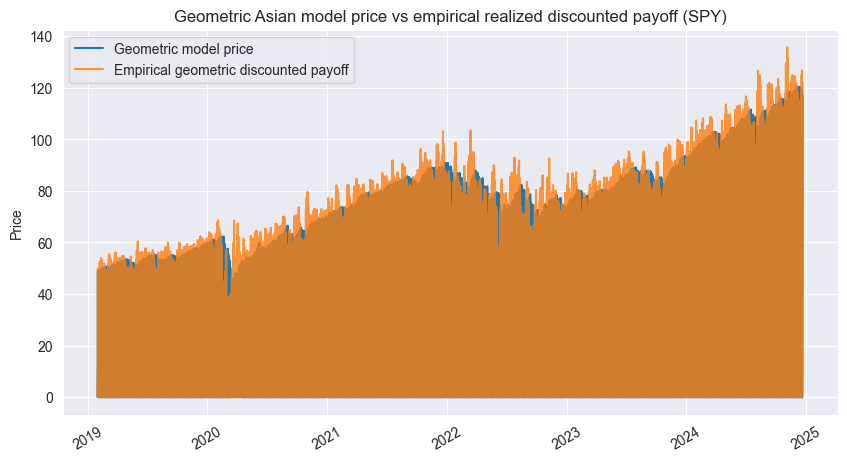

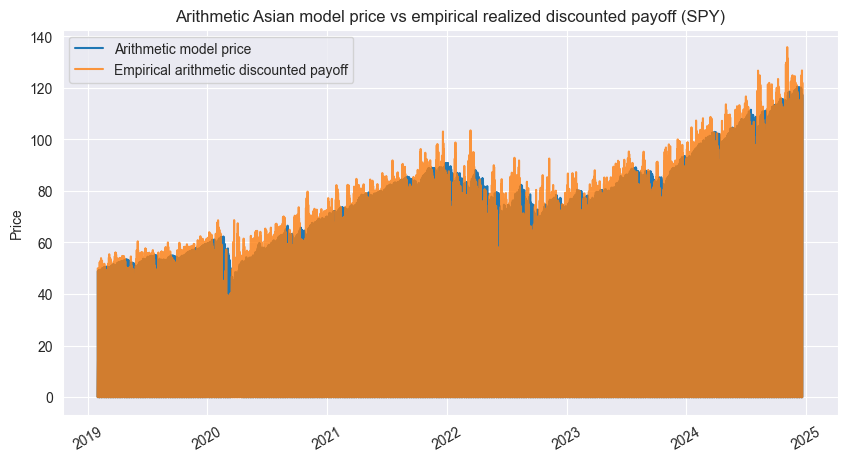

In [3]:
# --- Basic summary stats ---
print("Geometric Asian call option")
bias_G = (spy_results["geom_model"] - spy_results["geom_empirical"]).mean()
mae_G = np.mean(np.abs(spy_results["geom_model"] - spy_results["geom_empirical"]))
print(f"Mean model - empirical price: {bias_G:.4f}, MAE: {mae_G:.4f}")
print()
print("Arithmetic Asian call option")
bias_A = (spy_results["arit_model"] - spy_results["arit_empirical"]).mean()
mae_A = np.mean(np.abs(spy_results["arit_model"] - spy_results["arit_empirical"]))
print(f"Mean model - empirical price: {bias_A:.4f}, MAE: {mae_A:.4f}")

# --- Plot model vs empirical over time ---
# geometric
plt.figure(figsize=(10, 5))
plt.plot(spy_results["t0"], spy_results["geom_model"], label="Geometric model price")
plt.plot(
    spy_results["t0"],
    spy_results["geom_empirical"],
    label="Empirical geometric discounted payoff",
    alpha=0.8,
)
plt.legend()
plt.ylabel("Price")
plt.title(
    f"Geometric Asian model price vs empirical realized discounted payoff ({ticker})"
)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

# arithmetic
plt.figure(figsize=(10, 5))
plt.plot(spy_results["t0"], spy_results["arit_model"], label="Arithmetic model price")
plt.plot(
    spy_results["t0"],
    spy_results["arit_empirical"],
    label="Empirical arithmetic discounted payoff",
    alpha=0.8,
)
plt.legend()
plt.ylabel("Price")
plt.title(
    f"Arithmetic Asian model price vs empirical realized discounted payoff ({ticker})"
)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

Geometric call
P&L mean: $0.39
P&L std: $4.72
VaR (95): $-6.24
P&L median: $-0.17


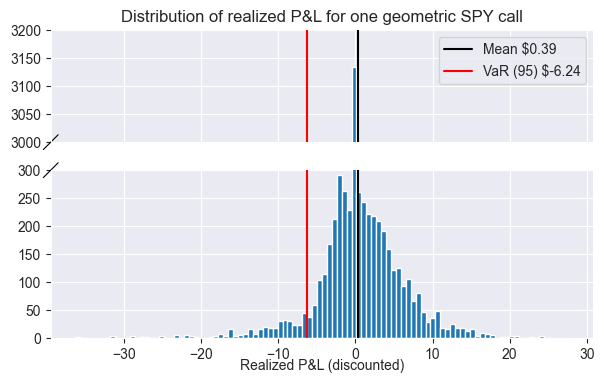

Arithmetic call
P&L mean: $0.40
P&L std: $4.72
VaR (95): $-6.20
P&L median: $-0.31


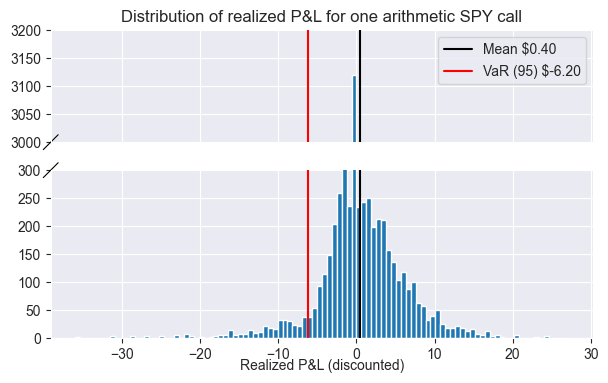

In [4]:
# --- VaR-like experiment: distribution of P&L if you sold at model price at t0 ---
# pnl = discounted_payoff - model_price (realized payoff minus model price)
spy_results["geom_pnl"] = spy_results["geom_empirical"] - spy_results["geom_model"]
spy_results["arit_pnl"] = spy_results["arit_empirical"] - spy_results["arit_model"]

n_bins = 100

# geometric
# summary metrics
print("Geometric call")
mean = spy_results["geom_pnl"].mean()
VaR = spy_results["geom_pnl"].quantile(0.05)
print(f"P&L mean: ${mean:.2f}")
print(f"P&L std: ${spy_results['geom_pnl'].std():.2f}")
print(f"VaR (95): ${VaR:.2f}")

# histogram
plt.figure(figsize=(7, 4))
bax = brokenaxes(ylims=((0, 300), (3000, 3200)))
n, bins = np.histogram(spy_results["geom_pnl"], bins=n_bins)
bax.hist(spy_results["geom_pnl"], bins=n_bins)
max_count_index = np.argmax(n)
largest_bin_start = bins[max_count_index]
largest_bin_end = bins[max_count_index + 1]
print(f"P&L median: ${(largest_bin_end+largest_bin_start)/2:.2f}")
bax.axvline(mean, label=f"Mean ${mean:.2f}", color="black")
bax.axvline(VaR, label=f"VaR (95) ${VaR:.2f}", color="red")
plt.title(f"Distribution of realized P&L for one geometric {ticker} call")
bax.set_xlabel("Realized P&L (discounted)")
bax.legend()
plt.show()

# arithmetic
# summary metrics
print("Arithmetic call")
mean = spy_results["arit_pnl"].mean()
VaR = spy_results["arit_pnl"].quantile(0.05)
print(f"P&L mean: ${mean:.2f}")
print(f"P&L std: ${spy_results['arit_pnl'].std():.2f}")
print(f"VaR (95): ${VaR:.2f}")

# histogram
plt.figure(figsize=(7, 4))
bax = brokenaxes(ylims=((0, 300), (3000, 3200)))
n, bins = np.histogram(spy_results["arit_pnl"], bins=n_bins)
bax.hist(spy_results["arit_pnl"], bins=n_bins)
max_count_index = np.argmax(n)
largest_bin_start = bins[max_count_index]
largest_bin_end = bins[max_count_index + 1]
print(f"P&L median: ${(largest_bin_end+largest_bin_start)/2:.2f}")
bax.axvline(mean, label=f"Mean ${mean:.2f}", color="black")
bax.axvline(VaR, label=f"VaR (95) ${VaR:.2f}", color="red")
plt.title(f"Distribution of realized P&L for one arithmetic {ticker} call")
bax.set_xlabel("Realized P&L (discounted)")
bax.legend()
plt.show()

### `VTI`

In [5]:
# --- CONFIG ---
ticker = "VTI"
expiry_days = 10  # length of Asian contract in calendar days
trail_window = 21  # days to compute realized vol before t0
r = 0.045  # risk-free rate (annual)
n_sims = 20_000  # MC paths for model pricing
n_steps = expiry_days  # MC time steps approx 1 per day
K_rel_values = [0.8, 0.9, 1.0, 1.1, 1.2]  # strike relative to spot, e.g., 1.0 = ATM
start_date = "2019-01-01"  # historical range start
end_date = "2024-12-31"  # historical range end

# helper: daily trading days ~ use business days index
prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()

# compute rolling realized vol series (one-sided trailing)
rv = realized_vol(prices, window_days=trail_window)

# choose t0 dates where we have enough trailing data and future window
all_dates = prices.index
usable_dates = []
for t0 in all_dates:
    # require t0 to have trailing window and future expiry window
    t0_idx = all_dates.get_loc(t0)
    if t0_idx - trail_window < 0:
        continue
    # compute end index for expiry
    expiry_date = t0 + pd.Timedelta(days=expiry_days)
    # find nearest trading day >= expiry_date
    if expiry_date > all_dates[-1]:
        break
    # we need expiry to be in index
    # find first trading day >= expiry_date
    future_idx = all_dates.get_indexer([expiry_date], method="bfill")[0]
    if future_idx == -1 or future_idx >= len(all_dates):
        continue
    # accept t0
    usable_dates.append(t0)

# # For speed, subsample usable_dates
# usable_dates = usable_dates[::20]

results = []
for t0 in usable_dates:
    for K_rel in K_rel_values:
        # get S0 at t0
        S0 = float(prices.loc[t0])
        # strike
        K = K_rel * S0

        # compute realized vol at t0 using trailing window
        sigma_t0 = float(rv.loc[t0])
        if np.isnan(sigma_t0) or sigma_t0 <= 0:
            continue

        # determine expiry trading day index
        expiry_date = t0 + pd.Timedelta(days=expiry_days)
        expiry_idx = prices.index.get_indexer([expiry_date], method="bfill")[0]
        T_days = expiry_idx - prices.index.get_indexer([t0])[0]
        # convert to years
        T_years = T_days / 252.0

        # --- Model price at t0 using realized vol ---
        # geometric
        model_G_price = gao_price(S0, K, sigma_t0, T_years, r)
        # arithmetic
        model_A_price = monte_carlo_asian(
            S0, K, sigma_t0, T_years, r, 0, n_sims, n_steps, return_distribution=False
        )

        # --- Empirical realized payoff computed from actual future prices ---
        # we need the actual average from t0->expiry_date inclusive
        # get slice of future prices from the first trading day after t0 up to expiry_idx
        t0_idx = prices.index.get_loc(t0)
        future_slice = prices.iloc[
            t0_idx + 1 : expiry_idx + 1
        ]  # average over next T_days (exclude t0)
        if len(future_slice) == 0:
            continue

        # geometric average
        G_T = np.exp(np.mean(np.log(future_slice)))
        discounted_G_payoff = max(G_T - K, 0) * np.exp(-r * T_years)

        # arithmetic average
        A_T = np.mean(future_slice)
        discounted_A_payoff = max(A_T - K, 0) * np.exp(-r * T_years)

        # store
        results.append(
            {
                "t0": t0,
                "S0": S0,
                "K": K,
                "K_rel": K_rel,
                "sigma_t0": sigma_t0,
                "T_years": T_years,
                "geom_model": model_G_price,
                "arit_model": model_A_price,
                "geom_empirical": discounted_G_payoff,
                "arit_empirical": discounted_A_payoff,
            }
        )

vti_results = pd.DataFrame(results)
vti_results = vti_results.dropna().reset_index(drop=True)
vti_results.to_csv(f"outputs/{ticker}_asian.csv")
vti_results

/tmp/ipykernel_17917/66548393.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_17917/66548393.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.loc[t0])
/tmp/ipykernel_17917/66548393.py:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_t0 = float(rv.loc[t0])


,t0,S0,K,K_rel,sigma_t0,T_years,geom_model,arit_model,geom_empirical,arit_empirical
0,2019-02-01,124.977318,99.981854,0.8,0.180144,0.023810,2.502755e+01,25.037865,25.696576,25.697597
1,2019-02-01,124.977318,112.479586,0.9,0.180144,0.023810,1.254320e+01,12.522507,13.212227,13.213249
2,2019-02-01,124.977318,124.977318,1.0,0.180144,0.023810,8.292559e-01,0.814294,0.727879,0.728900
3,2019-02-01,124.977318,137.475050,1.1,0.180144,0.023810,5.794446e-10,0.000000,0.000000,0.000000
4,2019-02-01,124.977318,149.972781,1.2,0.180144,0.023810,8.766102e-31,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
7410,2024-12-20,289.632812,231.706250,0.8,0.138568,0.019841,5.799489e+01,57.994937,60.162751,60.172343
7411,2024-12-20,289.632812,260.669531,0.9,0.138568,0.019841,2.905746e+01,29.067494,31.225319,31.234911
7412,2024-12-20,289.632812,289.632812,1.0,0.138568,0.019841,1.362095e+00,1.331579,2.287886,2.297478
7413,2024-12-20,289.632812,318.596094,1.1,0.138568,0.019841,7.388134e-18,0.000000,0.000000,0.000000


Geometric Asian call option
Mean model - empirical price: -0.1905, MAE: 1.3688

Arithmetic Asian call option
Mean model - empirical price: -0.1954, MAE: 1.3672


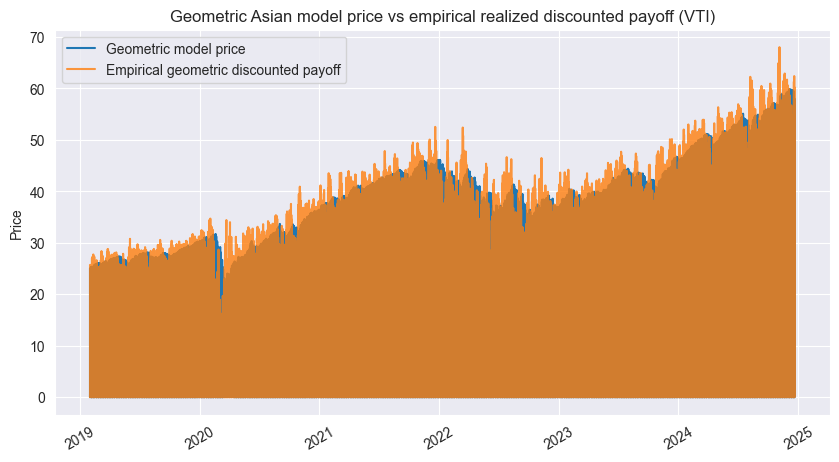

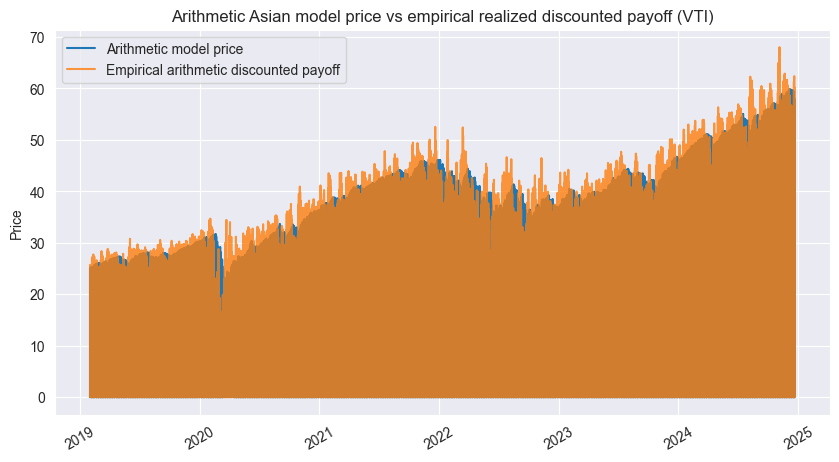

In [6]:
# --- Basic summary stats ---
print("Geometric Asian call option")
bias_G = (vti_results["geom_model"] - vti_results["geom_empirical"]).mean()
mae_G = np.mean(np.abs(vti_results["geom_model"] - vti_results["geom_empirical"]))
print(f"Mean model - empirical price: {bias_G:.4f}, MAE: {mae_G:.4f}")
print()
print("Arithmetic Asian call option")
bias_A = (vti_results["arit_model"] - vti_results["arit_empirical"]).mean()
mae_A = np.mean(np.abs(vti_results["arit_model"] - vti_results["arit_empirical"]))
print(f"Mean model - empirical price: {bias_A:.4f}, MAE: {mae_A:.4f}")

# --- Plot model vs empirical over time ---
# geometric
plt.figure(figsize=(10, 5))
plt.plot(vti_results["t0"], vti_results["geom_model"], label="Geometric model price")
plt.plot(
    vti_results["t0"],
    vti_results["geom_empirical"],
    label="Empirical geometric discounted payoff",
    alpha=0.8,
)
plt.legend()
plt.ylabel("Price")
plt.title(
    f"Geometric Asian model price vs empirical realized discounted payoff ({ticker})"
)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

# arithmetic
plt.figure(figsize=(10, 5))
plt.plot(vti_results["t0"], vti_results["arit_model"], label="Arithmetic model price")
plt.plot(
    vti_results["t0"],
    vti_results["arit_empirical"],
    label="Empirical arithmetic discounted payoff",
    alpha=0.8,
)
plt.legend()
plt.ylabel("Price")
plt.title(
    f"Arithmetic Asian model price vs empirical realized discounted payoff ({ticker})"
)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

Geometric call
P&L mean: $0.19
P&L std: $2.46
VaR (95): $-3.20
P&L median: $-0.09


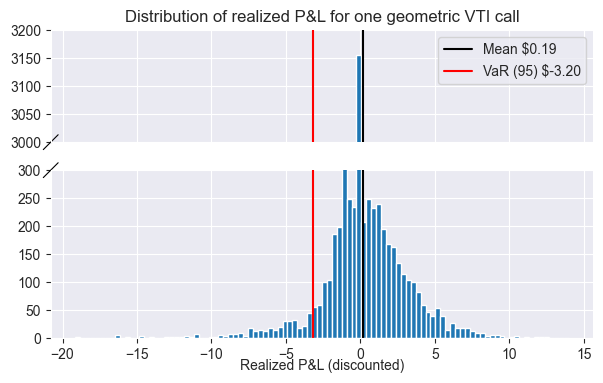

Arithmetic call
P&L mean: $0.20
P&L std: $2.45
VaR (95): $-3.22
P&L median: $-0.04


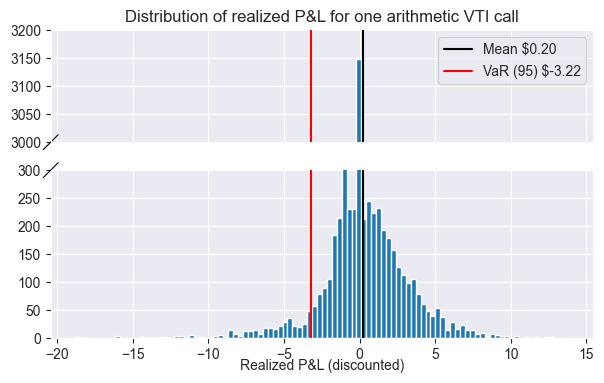

In [7]:
# --- VaR-like experiment: distribution of P&L if you sold at model price at t0 ---
# pnl = discounted_payoff - model_price (realized payoff minus model price)
vti_results["geom_pnl"] = vti_results["geom_empirical"] - vti_results["geom_model"]
vti_results["arit_pnl"] = vti_results["arit_empirical"] - vti_results["arit_model"]

n_bins = 100

# geometric
# summary metrics
print("Geometric call")
mean = vti_results["geom_pnl"].mean()
VaR = vti_results["geom_pnl"].quantile(0.05)
print(f"P&L mean: ${mean:.2f}")
print(f"P&L std: ${vti_results['geom_pnl'].std():.2f}")
print(f"VaR (95): ${VaR:.2f}")

# histogram
plt.figure(figsize=(7, 4))
bax = brokenaxes(ylims=((0, 300), (3000, 3200)))
n, bins = np.histogram(vti_results["geom_pnl"], bins=n_bins)
bax.hist(vti_results["geom_pnl"], bins=n_bins)
max_count_index = np.argmax(n)
largest_bin_start = bins[max_count_index]
largest_bin_end = bins[max_count_index + 1]
print(f"P&L median: ${(largest_bin_end+largest_bin_start)/2:.2f}")
bax.axvline(mean, label=f"Mean ${mean:.2f}", color="black")
bax.axvline(VaR, label=f"VaR (95) ${VaR:.2f}", color="red")
plt.title(f"Distribution of realized P&L for one geometric {ticker} call")
bax.set_xlabel("Realized P&L (discounted)")
bax.legend()
plt.show()

# arithmetic
# summary metrics
print("Arithmetic call")
mean = vti_results["arit_pnl"].mean()
VaR = vti_results["arit_pnl"].quantile(0.05)
print(f"P&L mean: ${mean:.2f}")
print(f"P&L std: ${vti_results['arit_pnl'].std():.2f}")
print(f"VaR (95): ${VaR:.2f}")

# histogram
plt.figure(figsize=(7, 4))
bax = brokenaxes(ylims=((0, 300), (3000, 3200)))
n, bins = np.histogram(vti_results["arit_pnl"], bins=n_bins)
bax.hist(vti_results["arit_pnl"], bins=n_bins)
max_count_index = np.argmax(n)
largest_bin_start = bins[max_count_index]
largest_bin_end = bins[max_count_index + 1]
print(f"P&L median: ${(largest_bin_end+largest_bin_start)/2:.2f}")
bax.axvline(mean, label=f"Mean ${mean:.2f}", color="black")
bax.axvline(VaR, label=f"VaR (95) ${VaR:.2f}", color="red")
plt.title(f"Distribution of realized P&L for one arithmetic {ticker} call")
bax.set_xlabel("Realized P&L (discounted)")
bax.legend()
plt.show()

# `AAPL`

In [8]:
# --- CONFIG ---
ticker = "AAPL"
expiry_days = 10  # length of Asian contract in calendar days
trail_window = 21  # days to compute realized vol before t0
r = 0.045  # risk-free rate (annual)
n_sims = 20_000  # MC paths for model pricing
n_steps = expiry_days  # MC time steps approx 1 per day
K_rel_values = [0.8, 0.9, 1.0, 1.1, 1.2]  # strike relative to spot, e.g., 1.0 = ATM
start_date = "2019-01-01"  # historical range start
end_date = "2024-12-31"  # historical range end

# helper: daily trading days ~ use business days index
prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()

# compute rolling realized vol series (one-sided trailing)
rv = realized_vol(prices, window_days=trail_window)

# choose t0 dates where we have enough trailing data and future window
all_dates = prices.index
usable_dates = []
for t0 in all_dates:
    # require t0 to have trailing window and future expiry window
    t0_idx = all_dates.get_loc(t0)
    if t0_idx - trail_window < 0:
        continue
    # compute end index for expiry
    expiry_date = t0 + pd.Timedelta(days=expiry_days)
    # find nearest trading day >= expiry_date
    if expiry_date > all_dates[-1]:
        break
    # we need expiry to be in index
    # find first trading day >= expiry_date
    future_idx = all_dates.get_indexer([expiry_date], method="bfill")[0]
    if future_idx == -1 or future_idx >= len(all_dates):
        continue
    # accept t0
    usable_dates.append(t0)

# # For speed, subsample usable_dates
# usable_dates = usable_dates[::20]

results = []
for t0 in usable_dates:
    for K_rel in K_rel_values:
        # get S0 at t0
        S0 = float(prices.loc[t0])
        # strike
        K = K_rel * S0

        # compute realized vol at t0 using trailing window
        sigma_t0 = float(rv.loc[t0])
        if np.isnan(sigma_t0) or sigma_t0 <= 0:
            continue

        # determine expiry trading day index
        expiry_date = t0 + pd.Timedelta(days=expiry_days)
        expiry_idx = prices.index.get_indexer([expiry_date], method="bfill")[0]
        T_days = expiry_idx - prices.index.get_indexer([t0])[0]
        # convert to years
        T_years = T_days / 252.0

        # --- Model price at t0 using realized vol ---
        # geometric
        model_G_price = gao_price(S0, K, sigma_t0, T_years, r)
        # arithmetic
        model_A_price = monte_carlo_asian(
            S0, K, sigma_t0, T_years, r, 0, n_sims, n_steps, return_distribution=False
        )

        # --- Empirical realized payoff computed from actual future prices ---
        # we need the actual average from t0->expiry_date inclusive
        # get slice of future prices from the first trading day after t0 up to expiry_idx
        t0_idx = prices.index.get_loc(t0)
        future_slice = prices.iloc[
            t0_idx + 1 : expiry_idx + 1
        ]  # average over next T_days (exclude t0)
        if len(future_slice) == 0:
            continue

        # geometric average
        G_T = np.exp(np.mean(np.log(future_slice)))
        discounted_G_payoff = max(G_T - K, 0) * np.exp(-r * T_years)

        # arithmetic average
        A_T = np.mean(future_slice)
        discounted_A_payoff = max(A_T - K, 0) * np.exp(-r * T_years)

        # store
        results.append(
            {
                "t0": t0,
                "S0": S0,
                "K": K,
                "K_rel": K_rel,
                "sigma_t0": sigma_t0,
                "T_years": T_years,
                "geom_model": model_G_price,
                "arit_model": model_A_price,
                "geom_empirical": discounted_G_payoff,
                "arit_empirical": discounted_A_payoff,
            }
        )

aapl_results = pd.DataFrame(results)
aapl_results = aapl_results.dropna().reset_index(drop=True)
aapl_results.to_csv(f"outputs/{ticker}_asian.csv")
aapl_results

/tmp/ipykernel_17917/3043043423.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_17917/3043043423.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.loc[t0])
/tmp/ipykernel_17917/3043043423.py:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_t0 = float(rv.loc[t0])


,t0,S0,K,K_rel,sigma_t0,T_years,geom_model,arit_model,geom_empirical,arit_empirical
0,2019-02-01,39.621471,31.697177,0.8,0.508350,0.023810,7.916718e+00,7.939502,9.212868,9.214658
1,2019-02-01,39.621471,35.659324,0.9,0.508350,0.023810,3.964564e+00,3.992567,5.254964,5.256753
2,2019-02-01,39.621471,39.621471,1.0,0.508350,0.023810,7.154785e-01,0.699912,1.297060,1.298849
3,2019-02-01,39.621471,43.583619,1.1,0.508350,0.023810,1.202203e-02,0.012443,0.000000,0.000000
4,2019-02-01,39.621471,47.545766,1.2,0.508350,0.023810,1.253097e-05,0.000030,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
7410,2024-12-20,253.589767,202.871814,0.8,0.139813,0.019841,5.077763e+01,50.800831,52.220430,52.231762
7411,2024-12-20,253.589767,228.230791,0.9,0.139813,0.019841,2.544129e+01,25.445758,26.884085,26.895417
7412,2024-12-20,253.589767,253.589767,1.0,0.139813,0.019841,1.202741e+00,1.182600,1.547740,1.559072
7413,2024-12-20,253.589767,278.948744,1.1,0.139813,0.019841,1.244230e-17,0.000000,0.000000,0.000000


Geometric Asian call option
Mean model - empirical price: -0.2735, MAE: 1.5773

Arithmetic Asian call option
Mean model - empirical price: -0.2792, MAE: 1.5784


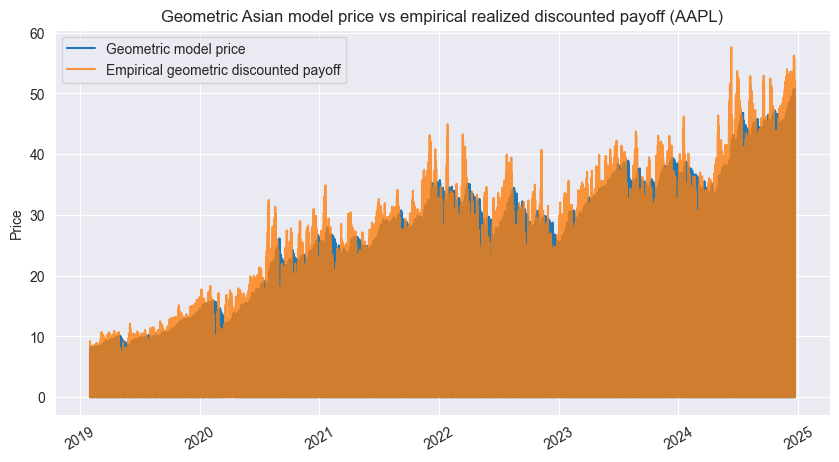

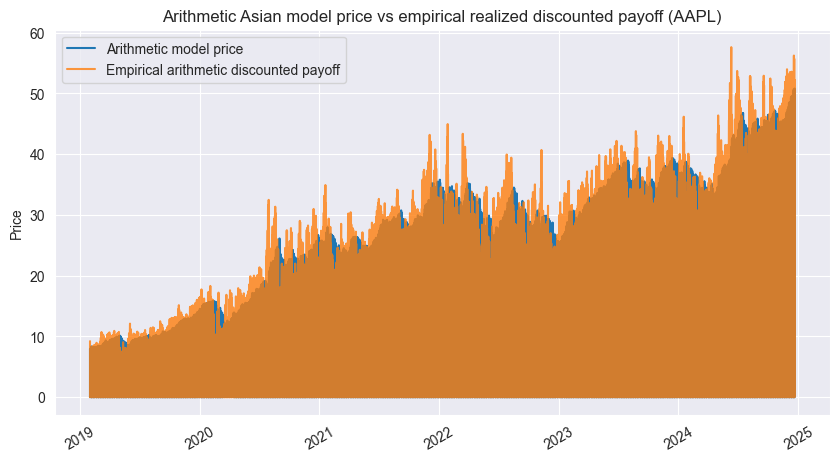

In [9]:
# --- Basic summary stats ---
print("Geometric Asian call option")
bias_G = (aapl_results["geom_model"] - aapl_results["geom_empirical"]).mean()
mae_G = np.mean(np.abs(aapl_results["geom_model"] - aapl_results["geom_empirical"]))
print(f"Mean model - empirical price: {bias_G:.4f}, MAE: {mae_G:.4f}")
print()
print("Arithmetic Asian call option")
bias_A = (aapl_results["arit_model"] - aapl_results["arit_empirical"]).mean()
mae_A = np.mean(np.abs(aapl_results["arit_model"] - aapl_results["arit_empirical"]))
print(f"Mean model - empirical price: {bias_A:.4f}, MAE: {mae_A:.4f}")

# --- Plot model vs empirical over time ---
# geometric
plt.figure(figsize=(10, 5))
plt.plot(aapl_results["t0"], aapl_results["geom_model"], label="Geometric model price")
plt.plot(
    aapl_results["t0"],
    aapl_results["geom_empirical"],
    label="Empirical geometric discounted payoff",
    alpha=0.8,
)
plt.legend()
plt.ylabel("Price")
plt.title(
    f"Geometric Asian model price vs empirical realized discounted payoff ({ticker})"
)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

# arithmetic
plt.figure(figsize=(10, 5))
plt.plot(aapl_results["t0"], aapl_results["arit_model"], label="Arithmetic model price")
plt.plot(
    aapl_results["t0"],
    aapl_results["arit_empirical"],
    label="Empirical arithmetic discounted payoff",
    alpha=0.8,
)
plt.legend()
plt.ylabel("Price")
plt.title(
    f"Arithmetic Asian model price vs empirical realized discounted payoff ({ticker})"
)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

Geometric call
P&L mean: $0.27
P&L std: $2.79
VaR (95): $-3.86
P&L median: $-0.11


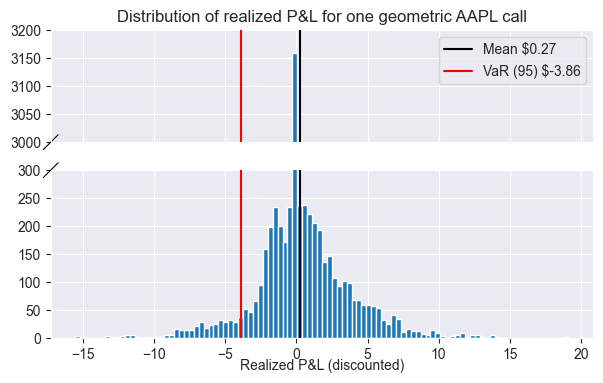

Arithmetic call
P&L mean: $0.28
P&L std: $2.79
VaR (95): $-3.87
P&L median: $-0.02


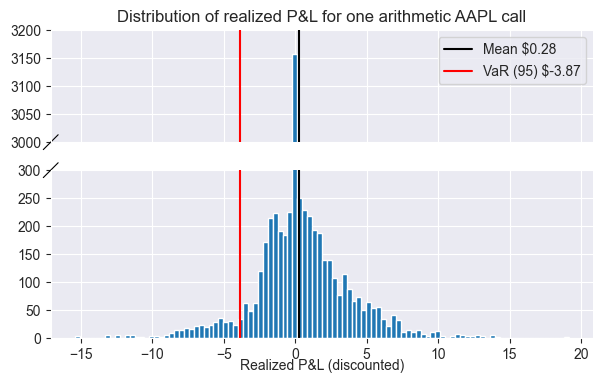

In [10]:
# --- VaR-like experiment: distribution of P&L if you sold at model price at t0 ---
# pnl = discounted_payoff - model_price (realized payoff minus model price)
aapl_results["geom_pnl"] = aapl_results["geom_empirical"] - aapl_results["geom_model"]
aapl_results["arit_pnl"] = aapl_results["arit_empirical"] - aapl_results["arit_model"]

n_bins = 100

# geometric
# summary metrics
print("Geometric call")
mean = aapl_results["geom_pnl"].mean()
VaR = aapl_results["geom_pnl"].quantile(0.05)
print(f"P&L mean: ${mean:.2f}")
print(f"P&L std: ${aapl_results['geom_pnl'].std():.2f}")
print(f"VaR (95): ${VaR:.2f}")

# histogram
plt.figure(figsize=(7, 4))
bax = brokenaxes(ylims=((0, 300), (3000, 3200)))
n, bins = np.histogram(aapl_results["geom_pnl"], bins=n_bins)
bax.hist(aapl_results["geom_pnl"], bins=n_bins)
max_count_index = np.argmax(n)
largest_bin_start = bins[max_count_index]
largest_bin_end = bins[max_count_index + 1]
print(f"P&L median: ${(largest_bin_end+largest_bin_start)/2:.2f}")
bax.axvline(mean, label=f"Mean ${mean:.2f}", color="black")
bax.axvline(VaR, label=f"VaR (95) ${VaR:.2f}", color="red")
plt.title(f"Distribution of realized P&L for one geometric {ticker} call")
bax.set_xlabel("Realized P&L (discounted)")
bax.legend()
plt.show()

# arithmetic
# summary metrics
print("Arithmetic call")
mean = aapl_results["arit_pnl"].mean()
VaR = aapl_results["arit_pnl"].quantile(0.05)
print(f"P&L mean: ${mean:.2f}")
print(f"P&L std: ${aapl_results['arit_pnl'].std():.2f}")
print(f"VaR (95): ${VaR:.2f}")

# histogram
plt.figure(figsize=(7, 4))
bax = brokenaxes(ylims=((0, 300), (3000, 3200)))
n, bins = np.histogram(aapl_results["arit_pnl"], bins=n_bins)
bax.hist(aapl_results["arit_pnl"], bins=n_bins)
max_count_index = np.argmax(n)
largest_bin_start = bins[max_count_index]
largest_bin_end = bins[max_count_index + 1]
print(f"P&L median: ${(largest_bin_end+largest_bin_start)/2:.2f}")
bax.axvline(mean, label=f"Mean ${mean:.2f}", color="black")
bax.axvline(VaR, label=f"VaR (95) ${VaR:.2f}", color="red")
plt.title(f"Distribution of realized P&L for one arithmetic {ticker} call")
bax.set_xlabel("Realized P&L (discounted)")
bax.legend()
plt.show()

# `MSFT`

In [11]:
# --- CONFIG ---
ticker = "MSFT"
expiry_days = 10  # length of Asian contract in calendar days
trail_window = 21  # days to compute realized vol before t0
r = 0.045  # risk-free rate (annual)
n_sims = 20_000  # MC paths for model pricing
n_steps = expiry_days  # MC time steps approx 1 per day
K_rel_values = [0.8, 0.9, 1.0, 1.1, 1.2]  # strike relative to spot, e.g., 1.0 = ATM
start_date = "2019-01-01"  # historical range start
end_date = "2024-12-31"  # historical range end

# helper: daily trading days ~ use business days index
prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()

# compute rolling realized vol series (one-sided trailing)
rv = realized_vol(prices, window_days=trail_window)

# choose t0 dates where we have enough trailing data and future window
all_dates = prices.index
usable_dates = []
for t0 in all_dates:
    # require t0 to have trailing window and future expiry window
    t0_idx = all_dates.get_loc(t0)
    if t0_idx - trail_window < 0:
        continue
    # compute end index for expiry
    expiry_date = t0 + pd.Timedelta(days=expiry_days)
    # find nearest trading day >= expiry_date
    if expiry_date > all_dates[-1]:
        break
    # we need expiry to be in index
    # find first trading day >= expiry_date
    future_idx = all_dates.get_indexer([expiry_date], method="bfill")[0]
    if future_idx == -1 or future_idx >= len(all_dates):
        continue
    # accept t0
    usable_dates.append(t0)

# # For speed, subsample usable_dates
# usable_dates = usable_dates[::20]

results = []
for t0 in usable_dates:
    for K_rel in K_rel_values:
        # get S0 at t0
        S0 = float(prices.loc[t0])
        # strike
        K = K_rel * S0

        # compute realized vol at t0 using trailing window
        sigma_t0 = float(rv.loc[t0])
        if np.isnan(sigma_t0) or sigma_t0 <= 0:
            continue

        # determine expiry trading day index
        expiry_date = t0 + pd.Timedelta(days=expiry_days)
        expiry_idx = prices.index.get_indexer([expiry_date], method="bfill")[0]
        T_days = expiry_idx - prices.index.get_indexer([t0])[0]
        # convert to years
        T_years = T_days / 252.0

        # --- Model price at t0 using realized vol ---
        # geometric
        model_G_price = gao_price(S0, K, sigma_t0, T_years, r)
        # arithmetic
        model_A_price = monte_carlo_asian(
            S0, K, sigma_t0, T_years, r, 0, n_sims, n_steps, return_distribution=False
        )

        # --- Empirical realized payoff computed from actual future prices ---
        # we need the actual average from t0->expiry_date inclusive
        # get slice of future prices from the first trading day after t0 up to expiry_idx
        t0_idx = prices.index.get_loc(t0)
        future_slice = prices.iloc[
            t0_idx + 1 : expiry_idx + 1
        ]  # average over next T_days (exclude t0)
        if len(future_slice) == 0:
            continue

        # geometric average
        G_T = np.exp(np.mean(np.log(future_slice)))
        discounted_G_payoff = max(G_T - K, 0) * np.exp(-r * T_years)

        # arithmetic average
        A_T = np.mean(future_slice)
        discounted_A_payoff = max(A_T - K, 0) * np.exp(-r * T_years)

        # store
        results.append(
            {
                "t0": t0,
                "S0": S0,
                "K": K,
                "K_rel": K_rel,
                "sigma_t0": sigma_t0,
                "T_years": T_years,
                "geom_model": model_G_price,
                "arit_model": model_A_price,
                "geom_empirical": discounted_G_payoff,
                "arit_empirical": discounted_A_payoff,
            }
        )

msft_results = pd.DataFrame(results)
msft_results = msft_results.dropna().reset_index(drop=True)
msft_results.to_csv(f"outputs/{ticker}_asian.csv")
msft_results

/tmp/ipykernel_17917/3335945135.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_17917/3335945135.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.loc[t0])
/tmp/ipykernel_17917/3335945135.py:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_t0 = float(rv.loc[t0])


,t0,S0,K,K_rel,sigma_t0,T_years,geom_model,arit_model,geom_empirical,arit_empirical
0,2019-02-01,96.345741,77.076593,0.8,0.317866,0.023810,1.928078e+01,19.297625,22.133804,22.135747
1,2019-02-01,96.345741,86.711167,0.9,0.317866,0.023810,9.656585e+00,9.650350,12.509547,12.511491
2,2019-02-01,96.345741,96.345741,1.0,0.317866,0.023810,1.103625e+00,1.090807,2.885290,2.887234
3,2019-02-01,96.345741,105.980315,1.1,0.317866,0.023810,2.960764e-04,0.000498,0.000000,0.000000
4,2019-02-01,96.345741,115.614890,1.2,0.317866,0.023810,2.900047e-11,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
7410,2024-12-20,434.214050,347.371240,0.8,0.198781,0.019841,8.693067e+01,86.993061,83.761545,83.794291
7411,2024-12-20,434.214050,390.792645,0.9,0.198781,0.019841,4.354801e+01,43.568183,40.378892,40.411638
7412,2024-12-20,434.214050,434.214050,1.0,0.198781,0.019841,2.881809e+00,2.792830,0.000000,0.000000
7413,2024-12-20,434.214050,477.635455,1.1,0.198781,0.019841,2.556286e-09,0.000000,0.000000,0.000000


Geometric Asian call option
Mean model - empirical price: -0.3932, MAE: 2.7421

Arithmetic Asian call option
Mean model - empirical price: -0.4014, MAE: 2.7413


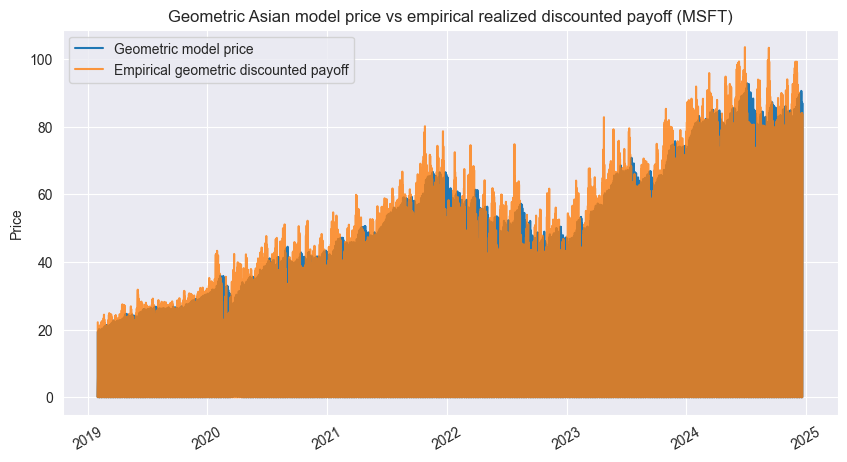

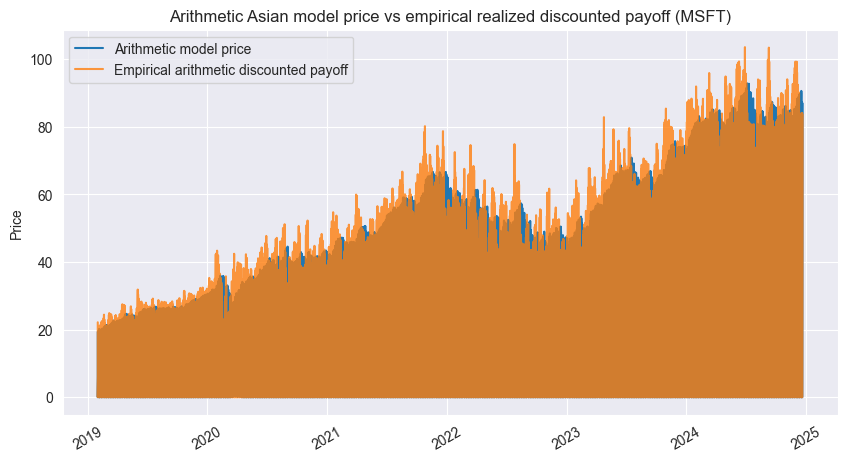

In [12]:
# --- Basic summary stats ---
print("Geometric Asian call option")
bias_G = (msft_results["geom_model"] - msft_results["geom_empirical"]).mean()
mae_G = np.mean(np.abs(msft_results["geom_model"] - msft_results["geom_empirical"]))
print(f"Mean model - empirical price: {bias_G:.4f}, MAE: {mae_G:.4f}")
print()
print("Arithmetic Asian call option")
bias_A = (msft_results["arit_model"] - msft_results["arit_empirical"]).mean()
mae_A = np.mean(np.abs(msft_results["arit_model"] - msft_results["arit_empirical"]))
print(f"Mean model - empirical price: {bias_A:.4f}, MAE: {mae_A:.4f}")

# --- Plot model vs empirical over time ---
# geometric
plt.figure(figsize=(10, 5))
plt.plot(msft_results["t0"], msft_results["geom_model"], label="Geometric model price")
plt.plot(
    msft_results["t0"],
    msft_results["geom_empirical"],
    label="Empirical geometric discounted payoff",
    alpha=0.8,
)
plt.legend()
plt.ylabel("Price")
plt.title(
    f"Geometric Asian model price vs empirical realized discounted payoff ({ticker})"
)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

# arithmetic
plt.figure(figsize=(10, 5))
plt.plot(msft_results["t0"], msft_results["arit_model"], label="Arithmetic model price")
plt.plot(
    msft_results["t0"],
    msft_results["arit_empirical"],
    label="Empirical arithmetic discounted payoff",
    alpha=0.8,
)
plt.legend()
plt.ylabel("Price")
plt.title(
    f"Arithmetic Asian model price vs empirical realized discounted payoff ({ticker})"
)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

Geometric call
P&L mean: $0.39
P&L std: $4.79
VaR (95): $-6.84
P&L median: $-0.12


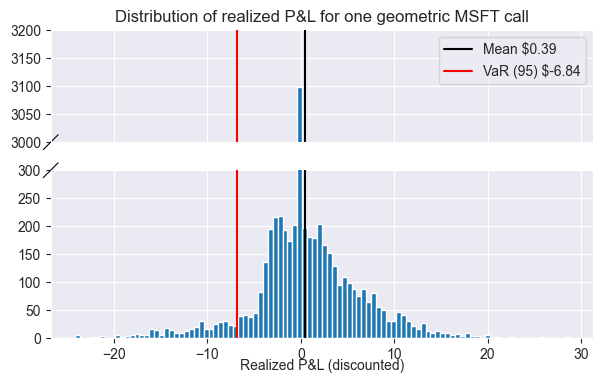

Arithmetic call
P&L mean: $0.40
P&L std: $4.79
VaR (95): $-6.83
P&L median: $-0.11


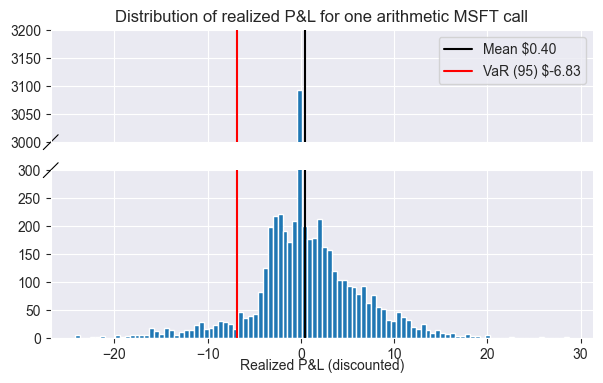

In [13]:
# --- VaR-like experiment: distribution of P&L if you sold at model price at t0 ---
# pnl = discounted_payoff - model_price (realized payoff minus model price)
msft_results["geom_pnl"] = msft_results["geom_empirical"] - msft_results["geom_model"]
msft_results["arit_pnl"] = msft_results["arit_empirical"] - msft_results["arit_model"]

n_bins = 100

# geometric
# summary metrics
print("Geometric call")
mean = msft_results["geom_pnl"].mean()
VaR = msft_results["geom_pnl"].quantile(0.05)
print(f"P&L mean: ${mean:.2f}")
print(f"P&L std: ${msft_results['geom_pnl'].std():.2f}")
print(f"VaR (95): ${VaR:.2f}")

# histogram
plt.figure(figsize=(7, 4))
bax = brokenaxes(ylims=((0, 300), (3000, 3200)))
n, bins = np.histogram(msft_results["geom_pnl"], bins=n_bins)
bax.hist(msft_results["geom_pnl"], bins=n_bins)
max_count_index = np.argmax(n)
largest_bin_start = bins[max_count_index]
largest_bin_end = bins[max_count_index + 1]
print(f"P&L median: ${(largest_bin_end+largest_bin_start)/2:.2f}")
bax.axvline(mean, label=f"Mean ${mean:.2f}", color="black")
bax.axvline(VaR, label=f"VaR (95) ${VaR:.2f}", color="red")
plt.title(f"Distribution of realized P&L for one geometric {ticker} call")
bax.set_xlabel("Realized P&L (discounted)")
bax.legend()
plt.show()

# arithmetic
# summary metrics
print("Arithmetic call")
mean = msft_results["arit_pnl"].mean()
VaR = msft_results["arit_pnl"].quantile(0.05)
print(f"P&L mean: ${mean:.2f}")
print(f"P&L std: ${msft_results['arit_pnl'].std():.2f}")
print(f"VaR (95): ${VaR:.2f}")

# histogram
plt.figure(figsize=(7, 4))
bax = brokenaxes(ylims=((0, 300), (3000, 3200)))
n, bins = np.histogram(msft_results["arit_pnl"], bins=n_bins)
bax.hist(msft_results["arit_pnl"], bins=n_bins)
max_count_index = np.argmax(n)
largest_bin_start = bins[max_count_index]
largest_bin_end = bins[max_count_index + 1]
print(f"P&L median: ${(largest_bin_end+largest_bin_start)/2:.2f}")
bax.axvline(mean, label=f"Mean ${mean:.2f}", color="black")
bax.axvline(VaR, label=f"VaR (95) ${VaR:.2f}", color="red")
plt.title(f"Distribution of realized P&L for one arithmetic {ticker} call")
bax.set_xlabel("Realized P&L (discounted)")
bax.legend()
plt.show()

### A few remarks about the results
Note first that the average P&L is positive in all cases, but recall that the B-S/M-C pricing for European options seems to be systematically underpricing calls compared to their real market prices, which we can assume to be a reasonable proxy for future discounted realized payoffs.  A similar phenomenon is probably happening for Asian options too, and could explain the consistent positive average P&L, and this likely reflects the difference between the risk-neutral dynamics assumed by the model and the empirical (real-world) dynamics — in particular, the presence of a volatility risk premium or deviations from log-normality.

Note also that, although the mean P&L is positive, the median is negative and has a very large count. This indicates that most hedging periods would result in small losses, occasionally offset by larger favorable outcomes. This pattern seems typical of short option exposure and may reflect both non-Gaussian return dynamics and the absence of a volatility risk premium in the model.

Finally, note that the standard deviation and 95% Value-at-Risk of P&L substantially exceed the mean, indicating that the model’s apparent profitability is not statistically or economically significant. The large dispersion and fat left tail imply that a market-maker using this strategy would face substantial risk of loss despite a positive expected P&L.